In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [6]:


# Define the path to the folder
folder_path = 'test'

# List all files in the directory
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Create an empty list to store dataframes
dfs = []

# Loop through each file
for filename in all_files:
    # Extract the robot name from the filename
    robot_name = filename.split('_')[-1].replace('.csv', '')
    
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    
    # Add a new column for the robot name
    df['robot_name'] = robot_name
    
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes in the list
combined_df = pd.concat(dfs, ignore_index=True)

print(combined_df)

# Print the number of distinct robots (which is equivalent to the number of CSV files)
num_robots = len(all_files)
print(f'There are {num_robots} distinct robots.')


     Unnamed: 0            timestamp  trans_vel   rot_vel  tf_pose_x  \
0             0  1693209518413090747   0.000000  0.000000        NaN   
1             1  1693209519413090747   0.000000  0.000000   2.000000   
2             2  1693209520413090747   0.000000  0.000000   2.000000   
3             3  1693209521413090747   0.000025  0.147668   1.999924   
4             4  1693209522413090747  -0.000013  0.114166   2.000152   
..          ...                  ...        ...       ...        ...   
463         229  1693209747413090747   0.025437 -0.126807  -0.244681   
464         230  1693209748413090747   0.057134 -0.127285  -0.265514   
465         231  1693209749413090747   0.039150 -0.085225  -0.292764   
466         232  1693209750413090747   0.121546 -0.037449  -0.338536   
467         233  1693209751413090747   0.059663 -0.025235  -0.382990   

     tf_pose_y  tf_pose_theta  min_obstacle_dist  rotation_sign  robot_name  
0          NaN            NaN                0.0         

In [7]:
import pandas as pd
import os

# Define the path to the folder
folder_path = 'test'

# List all files in the directory
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Dictionary to hold the data. Keys are robot names, and values are the rotation_sign columns.
data = {}

# Loop through each file
for filename in all_files:
    # Extract the robot name from the filename
    robot_name = filename.split('_')[-1].replace('.csv', '')
    
    file_path = os.path.join(folder_path, filename)
    df = pd.read_csv(file_path)
    
    # Extract the 'rotation_sign' column and store it in the dictionary with the robot name as the key.
    data[robot_name] = df['rotation_sign'].tolist()

# Convert the dictionary to a DataFrame
rotation_sign_df = pd.DataFrame(data)

# Remove the first 4 rows
rotation_sign_df = rotation_sign_df.iloc[10:]

# Reset the index after dropping rows (optional, but can be helpful for clarity)
rotation_sign_df.reset_index(drop=True, inplace=True)

print(rotation_sign_df)



     turtlebot5  turtlebot1
0           NaN         NaN
1           NaN         NaN
2           NaN         NaN
3           NaN         NaN
4           NaN         NaN
..          ...         ...
219         NaN         NaN
220         NaN         NaN
221         NaN         NaN
222         NaN         NaN
223         NaN         NaN

[224 rows x 2 columns]


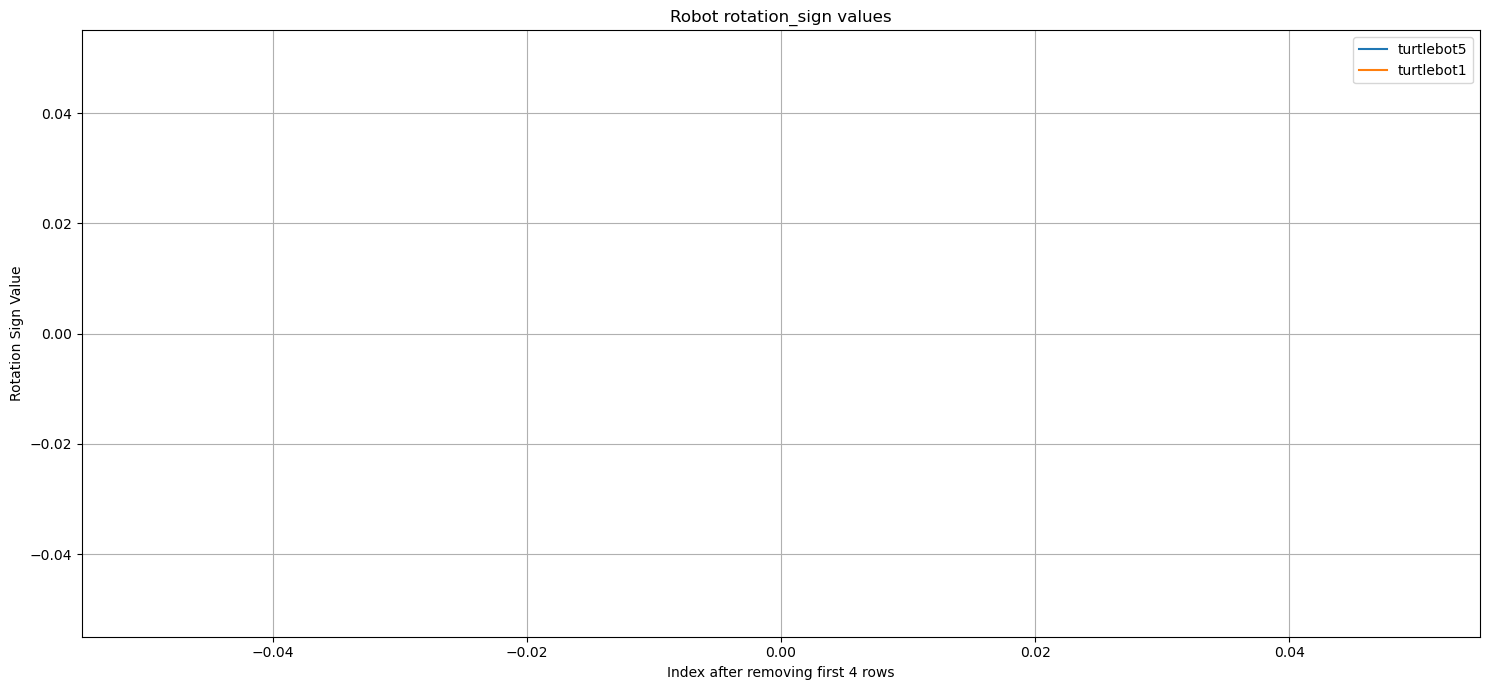

In [8]:
# Plot
plt.figure(figsize=(15,7))
for robot_name in rotation_sign_df.columns:
    plt.plot(rotation_sign_df[robot_name], label=robot_name)

plt.legend(loc="best")
plt.title("Robot rotation_sign values")
plt.xlabel("Index after removing first 4 rows")
plt.ylabel("Rotation Sign Value")
plt.grid(True)
plt.tight_layout()
plt.show()

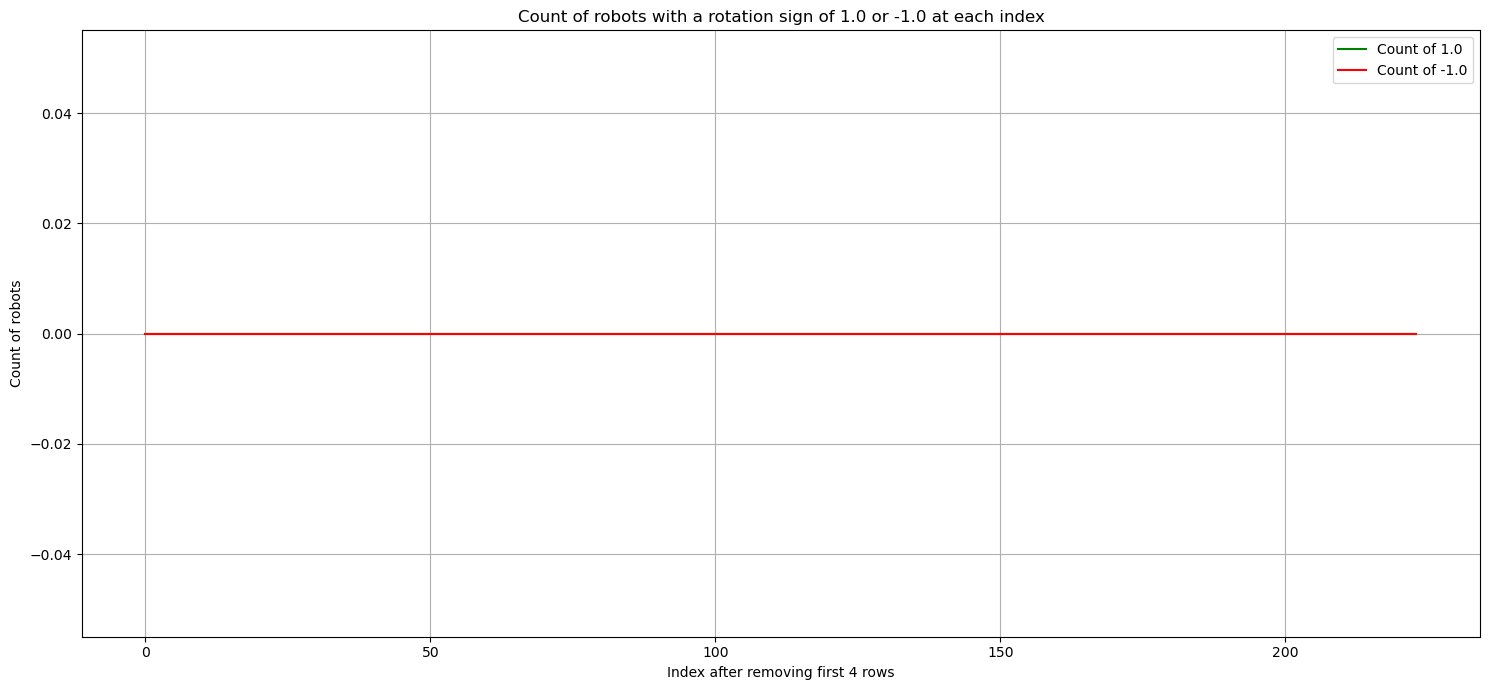

In [9]:
count_positive = (rotation_sign_df == 1.0).sum(axis=1)
count_negative = (rotation_sign_df == -1.0).sum(axis=1)

# Plot
plt.figure(figsize=(15,7))
plt.plot(count_positive, label="Count of 1.0", color="green")
plt.plot(count_negative, label="Count of -1.0", color="red")

plt.legend(loc="best")
plt.title("Count of robots with a rotation sign of 1.0 or -1.0 at each index")
plt.xlabel("Index after removing first 4 rows")
plt.ylabel("Count of robots")
plt.grid(True)
plt.tight_layout()
plt.show()